In [17]:
library(dplyr)
library(stringr)
library(readr)
library(tibble)
library(tidyr)
library(lfe)
library(scales)
library(repr)
library(stargazer)
options(repr.plot.width=10, repr.plot.height=10, digits=3)

In [18]:
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/data.RData')

In [19]:
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/social_adj_matrix.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/geo_adjacency_matrix.Rdata')

In [20]:
fp <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/'
weather       <- read_csv(str_c(fp, 'PROCESSED_DATA/county_weather.csv'))

Parsed with column specification:
cols(
  county_fips = col_character(),
  dt = col_date(format = ""),
  PRCP = col_double(),
  TMAX = col_double()
)



In [21]:
weather_wide <- weather %>%
    select(-TMAX) %>%
    pivot_wider(names_from = county_fips, values_from = PRCP) %>%
    select(-dt) %>% 
    as.matrix()

In [22]:
colnames(weather_wide) <- as.character(as.integer(colnames(weather_wide)))

In [23]:
# Filter down to county fips we see
fips_in_panel <- as.character(unique(panel$county_fips))
indices <- which(colnames(social_adj_matrix) %in% fips_in_panel)
social_adj_matrix_for_conley <- social_adj_matrix[indices, indices]
geo_adj_matrix_for_conley <- geo_adj_matrix_bayes[indices, indices]

# Set diagonals equal to 1
#diag(social_adj_matrix_for_conley) <- 1

In [24]:
weather_indices <- which(colnames(weather_wide) %in% fips_in_panel)

In [25]:
weather_wide_for_conley <- weather_wide[, weather_indices]

In [26]:
# remove day fixed effects
weather_wide_dm <- weather_wide_for_conley - rowMeans(weather_wide_for_conley)

## Basic weather correlations

In [27]:
weather_cor <- cor(weather_wide_dm)

In [28]:
saveRDS(weather_cor, '/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/weather_cor.RDS')

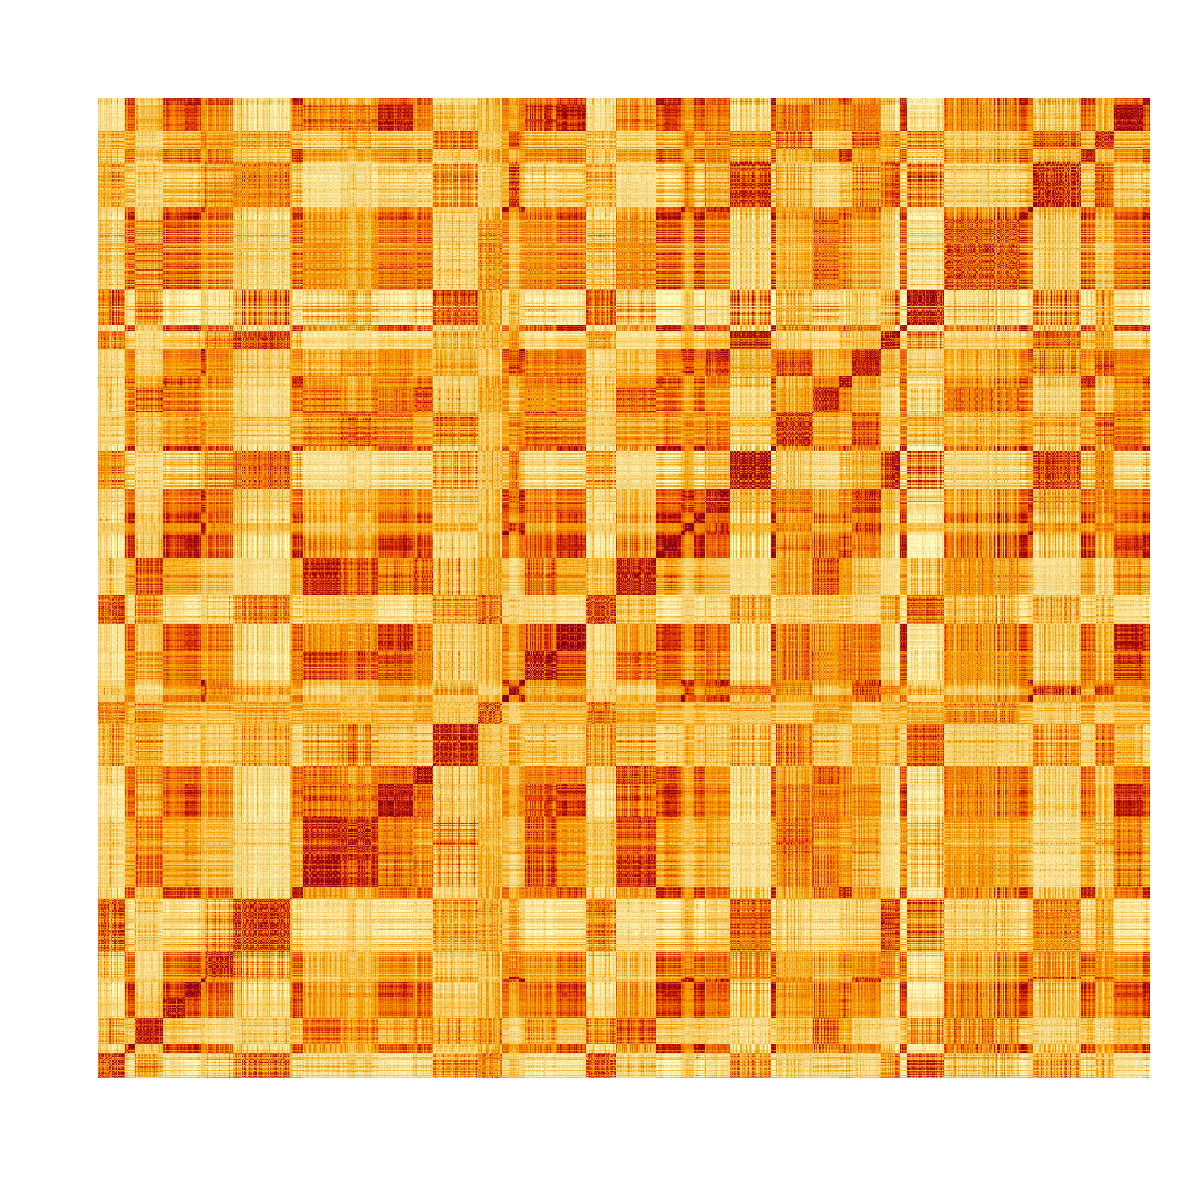

In [31]:
image(weather_cor, axes = FALSE)

In [36]:
png("../output/weather_cor_matrix.png", width = 2000, height = 2000)
image(weather_cor, axes = FALSE)
dev.off()

png 
  2

## Average peer weather and its correlation

In [37]:
ww_sci <- weather_wide_dm %*% social_adj_matrix_for_conley

In [38]:
weather_sci_cor <- cor(ww_sci)

In [41]:
saveRDS(weather_sci_cor, '/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/weather_sci_alter_cor.RDS')

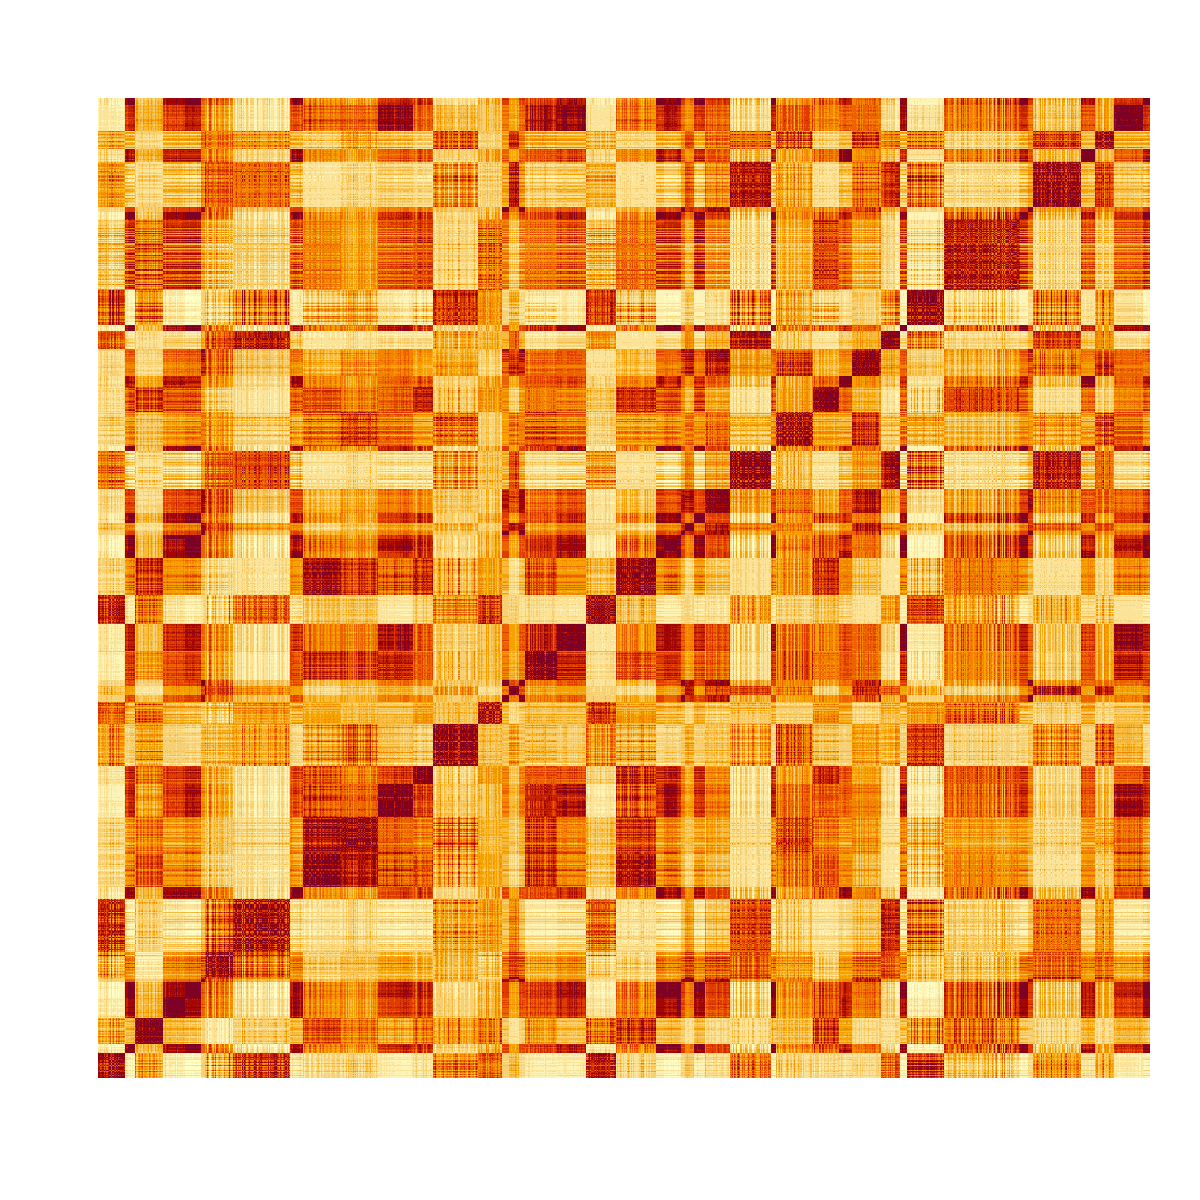

In [39]:
image(weather_sci_cor, axes = FALSE)

In [40]:
png("../output/weather_sci_alter_cor_matrix.png", width = 2000, height = 2000)
image(weather_sci_cor, axes = FALSE)
dev.off()

png 
  2

## Compute clusters of weather

In [43]:
weather_hclust <- hclust(as.dist(1-weather_cor))

In [44]:
weather_clusters <- cutree(weather_hclust, 20) %>% as.data.frame() %>% rownames_to_column("county_fips")
names(weather_clusters)[2] <- "weather_cluster"

In [47]:
table(weather_clusters$weather_cluster)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
 67  37 109  14 112 470 144  70 150 104  72 122 147  85 210 308  74  21 120  66 

In [48]:
saveRDS(weather_clusters, '/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/weather_clusters.RDS')